In [1]:
from pathlib import Path
from pprint import pprint

import re
import torch
import torch.nn as nn
import datasets
from datasets import concatenate_datasets
from tqdm import tqdm
from transformers import BertForSequenceClassification
from transformers import BertForMaskedLM, BertTokenizer
import numpy as np
import torch
import spacy
import benepar
import nltk

from common.data_utils import get_dataset
from model.tokenizer import PhraseTokenizer
from model.attacker import Attacker
from model.substitution import *

[nltk_data] Downloading package benepar_en3 to
[nltk_data]     /home/coraline/nltk_data...
[nltk_data]   Package benepar_en3 is already up-to-date!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [3]:
model_name = "bert-large-uncased-whole-word-masking"
tokenizer = BertTokenizer.from_pretrained(model_name)
mlm_model = BertForMaskedLM.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Generate Adversarial Examples for the Target Sequence (multi-granuality)

In [43]:
from model.tokenizer import PhraseTokenizer
from fuzzingbook.GrammarFuzzer import display_tree

Display parse tree

In [53]:
def _parse_error(s, match, expecting):
    """
    Display a friendly error message when parsing a tree string fails.
    :param s: The string we're parsing.
    :param match: regexp match of the problem token.
    :param expecting: what we expected to see instead.
    """
    # Construct a basic error message
    if match == "end-of-string":
        pos, token = len(s), "end-of-string"
    else:
        pos, token = match.start(), match.group()
    msg = "read(): expected %r but got %r\n%sat index %d." % (
        expecting,
        token,
        " " * 12,
        pos,
    )
    # Add a display showing the error token itsels:
    s = s.replace("\n", " ").replace("\t", " ")
    offset = pos
    if len(s) > pos + 10:
        s = s[: pos + 10] + "..."
    if pos > 10:
        s = "..." + s[pos - 10 :]
        offset = 13
    msg += '\n{}"{}"\n{}^'.format(" " * 16, s, " " * (17 + offset))
    raise ValueError(msg)

In [61]:
def fromstring(
        s,
        brackets="()",
        read_node=None,
        read_leaf=None,
        node_pattern=None,
        leaf_pattern=None,
        remove_empty_top_bracketing=False,
    ):
        """
        Read a bracketed tree string and return the resulting tree.
        Trees are represented as nested brackettings, such as::

          (S (NP (NNP John)) (VP (V runs)))

        :type s: str
        :param s: The string to read

        :type brackets: str (length=2)
        :param brackets: The bracket characters used to mark the
            beginning and end of trees and subtrees.

        :type read_node: function
        :type read_leaf: function
        :param read_node, read_leaf: If specified, these functions
            are applied to the substrings of ``s`` corresponding to
            nodes and leaves (respectively) to obtain the values for
            those nodes and leaves.  They should have the following
            signature:

               read_node(str) -> value

            For example, these functions could be used to process nodes
            and leaves whose values should be some type other than
            string (such as ``FeatStruct``).
            Note that by default, node strings and leaf strings are
            delimited by whitespace and brackets; to override this
            default, use the ``node_pattern`` and ``leaf_pattern``
            arguments.

        :type node_pattern: str
        :type leaf_pattern: str
        :param node_pattern, leaf_pattern: Regular expression patterns
            used to find node and leaf substrings in ``s``.  By
            default, both nodes patterns are defined to match any
            sequence of non-whitespace non-bracket characters.

        :type remove_empty_top_bracketing: bool
        :param remove_empty_top_bracketing: If the resulting tree has
            an empty node label, and is length one, then return its
            single child instead.  This is useful for treebank trees,
            which sometimes contain an extra level of bracketing.

        :return: A tree corresponding to the string representation ``s``.
            If this class method is called using a subclass of Tree,
            then it will return a tree of that type.
        :rtype: Tree
        """
        if not isinstance(brackets, str) or len(brackets) != 2:
            raise TypeError("brackets must be a length-2 string")
        if re.search(r"\s", brackets):
            raise TypeError("whitespace brackets not allowed")
        # Construct a regexp that will tokenize the string.
        open_b, close_b = brackets
        open_pattern, close_pattern = (re.escape(open_b), re.escape(close_b))
        if node_pattern is None:
            node_pattern = fr"[^\s{open_pattern}{close_pattern}]+"
        if leaf_pattern is None:
            leaf_pattern = fr"[^\s{open_pattern}{close_pattern}]+"
        token_re = re.compile(
            r"%s\s*(%s)?|%s|(%s)"
            % (open_pattern, node_pattern, close_pattern, leaf_pattern)
        )
        # Walk through each token, updating a stack of trees.
        stack = [(None, [])]  # list of (node, children) tuples
        for match in token_re.finditer(s):
            token = match.group()
            # Beginning of a tree/subtree
            if token[0] == open_b:
                if len(stack) == 1 and len(stack[0][1]) > 0:
                    _parse_error(s, match, "end-of-string")
                label = token[1:].lstrip()
                if read_node is not None:
                    label = read_node(label)
                stack.append((label, []))
            # End of a tree/subtree
            elif token == close_b:
                if len(stack) == 1:
                    if len(stack[0][1]) == 0:
                        _parse_error(s, match, open_b)
                    else:
                        _parse_error(s, match, "end-of-string")
                label, children = stack.pop()
                if len(children) > 0 and type(children[0]) == str:
                    children = [(children[0], [])]
                stack[-1][1].append((label, children))
            # Leaf node
            else:
                if len(stack) == 1:
                    _parse_error(s, match, open_b)
                if read_leaf is not None:
                    token = read_leaf(token)
                stack[-1][1].append(token)

        # check that we got exactly one complete tree.
        if len(stack) > 1:
            _parse_error(s, "end-of-string", close_b)
        elif len(stack[0][1]) == 0:
            _parse_error(s, "end-of-string", open_b)
        else:
            assert stack[0][0] is None
            assert len(stack[0][1]) == 1
        tree = stack[0][1][0]

        # If the tree has an extra level with node='', then get rid of
        # it.  E.g.: "((S (NP ...) (VP ...)))"
        if remove_empty_top_bracketing and tree._label == "" and len(tree) == 1:
            tree = tree[0]
        # return the tree.
        return tree

In [62]:
nlp = spacy.load("en_core_web_md")
nlp.add_pipe('benepar', config={'model': 'benepar_en3'})

def tree_parse2(input_sentence):
    doc = nlp(input_sentence)

    whole_string = '('
    for tree in doc.sents:
        whole_string += tree._.parse_string

    return whole_string + ')'

In [56]:
# other examples for tokenizer
# sentence = "I will take over from now on."
# sentence = "The movie is great as far as I think."
# sentence = "The actors fall in love at first sight."
# sentence = "I will meet you at the train station."

In [57]:
phrase_tok = PhraseTokenizer()

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'benepar', 'merge_phrases']


In [80]:
tgt_seq = "I have to disagree with these other reviews.  Presbyterian is a joke.  Unfortunately our primary care physician is right around the corner, and affiliated with Presbyterian as well, and so any time they want to order up something that they can't handle in the office, guess where they send us?\\n\\nTo make matters worse, the place is always full (or overfull), always understaffed, and always incapable of handling anything.  The emergency department is horrid, but to make matters worse, it's better than being admitted.\\n\\nIn one of the worst cases of mismanagement ever, what should have been a simple examination - passed from our regular doctor - ended up being at least 12 hours in the emergency room while we waited for a regular room, then several days (yes days) in the hospital itself while they proceeded to run a whopping one test per day.  That's right - one test per day!\\n\\nThe test would usually be run in mid-morning, and the results would come back mid-afternoon, at which point they would try and find someone to interpret the test results, which could take until after dinner, and by the time that happened, it would be night time, and then another test would be ordered for the next day.  It was simply pathetic.\\n\\nWhatever you do, do not go to the emergency room at Presbyterian."
tgt_seq = "Monday night drink specials and an amazingly musical performance will be provided to you with a 5 dollar cover.. What more could you ask for?\\n\\n\\nThis building breeds history and I was proud to experience it my last night in Charlotte."
tgt_seq = "Sundays used to be all you can drink vodka for 10 dollar cover... After paying our cover they let us know that beginning this week vodka drinks are 2 dollars... Why would anyone come on Sunday if they're pouring 2 dollar glasses of cranberry juice?"
tgt_seq = "Though the Freedom Dr. K-Mart looks like the setting of a post-apocalyptic film and the entire chain is past its prime, you can find some 'trinkets' for cheap on the inside.  \\n\\nThis K-Mart has some affordable home furninishing knock-offs (by cheap, I mean cheaper than Target/IKEA).  While it some of it is dated, K-Mart still carries the much-touted Martha Stewart brands.  I've found a 'runner' rug and bedspread that both look like something from department stores.  The same can be said for the furniture, so don't hate on my stylish house. \\n\\nThe clothing department is slightly dicier, but I have scavenged some faddish clothes (think Gap 3 years ago) among the Big Bubba t-shirts and overalls.  Their young men's section has good deals at the end of the season, like utility shirts or those really metrosexual boot-cut jeans for less than $15.  Yeah....really.\\n\\nThe rest of the store is pretty much filler.  If you actually go to this K-Mart ( or any K-Mart) looking for a decent selection of sporting goods/shoes/electronics, you will likely pay more than other big box retailers or be appalled by the selection.  If you're like me and approach K-Mart shopping like thrift store diving, you will be pleasantly surprised. Can't decide then if visiting K-Mart is frugal or frivolous, but who doesn't need another cheap belt?"
tgt_seq = "Ditto the other ratings for UVerse customer service, at least once you get past the fabulous sales people. My install was scheduled for between 9-11 am on a Saturday, dude called at 2:30 to say he was the \\\"\"outside guy\\\"\" and was on his way. Was indignant when I asked about the earlier time frame (actually I laughed when I answered the phone and found out who he was....3.5 hrs late!), but I let him come and do at least the outside work. Called the number on my scheduled appt email at 3:30, got a woman who knew nothing about my issues, tried to transfer me to dispatch, transfer failed. She called me back, I asked for a supervisor and was on hold for 15 minutes. She called back again, tried to transfer me to somebody else, said there was a \\\"\"problem\\\"\" with my order, but she couldn't tell me what it was. After another 20 minutes on hold, I hung up. She called back once more, told me she would call me as soon as the department was available - never heard back. Unbelievable! Not thrilled with Time Warner or most of their contracted install/repair folks, but at least when they are going to be late or have to reschedule, they call! DON'T DO IT!"
tgt_seq = "Red alert. Red Alert. \\n\\nIf you are looking for good mobile phone customer service, this is not the store. I'm changing my provider to Verizon or AT&T after the experience I had last night. Here's how it went down....\\n\\nI headed in around 6:30pm as my contract expired so I needed to upgrade my phone and sign on for two more years. When I entered, I noticed around eight employees out front and three in the back...so I thought to myself, this won't take long, there are a ton of people working. I signed in with the \\\"\"receptionist\\\"\" who told me the wait to buy a new phone would be 10 minutes. No biggie, I told her, I'll just go check out all the gadgets. \\n\\nForty minutes later I was still waiting - and showing as third on the list for service. Now this wouldn't be a big deal if I wasn't watching the employees talk to each other and head into the back for long periods of time while customers were waiting out front. I literally timed two people between customers - one waited over 15 minutes before helping someone else and the second employee wasn't helping anyone when I left and it had been 20 minutes since his last customer. \\n\\nNeedless to say, I left the store...but not before telling them to take me off the list so the poor people in line after me didn't have to wait even longer. I will not be back and have been researching other providers today."
tgt_seq = "We went on a Saturday morning and had to wait almost an hour to be seated.  My egg white omelette was runny, so I sent it back.  We are now an hour and twenty minutes into our dining experience and I still have no food that is edible.  When the omelette returned, they had done something to the eggs to make them ultra-fluffy, which sounds like it would be good, but it wasn't.  It was literally like eating a kitchen sponge.  My son and husband got pancakes and said that the ones we make at home are better.\\n\\nOh, I should add that we went to the one by the Target near uptown."
tgt_seq = "Recently joined the YMCA and this is my \\\"\"home\\\"\" ymca.  I LOVE the equipment and 'most' of the staff.  I have hit the gym (been a member about 30 days) at very varied times but have settled on 5 am for strength training (mon/wed/fri) and 3pm (ish) for cardio (Tues/Thurs/Sat).  At either time it isn't overwhelmingly crowded.\\n\\nI will say at 5 am (and I assume other times) there are plenty of meat heads in the weight room - grunting, slamming weights, flexing in the mirror.  I also  find it entertaining to see the fashion show that occurs in the weight room (I like to ppl watch between sets).   I have NEVER seen so many coordinated work clothes in my entire life.  Matching shows, pants/shorts/shirts and often times hats.  None of this bothers me, it is just entertaining.\\n\\nI have not met anyone very friendly there and I assume that is because it is the \\\"\"SoPark\\\"\" area - but since I don't go to the gym to socialize I guess it doesn't matter."
tgt_seq = "Laser quest is a fun experience for kids of all ages, but the adults that play at this establishment, honestly kind of creep me out. The best time to bring your children here is during the middle of the week, because there is always an abundance of birthday parties on the weekend, and it can take hours before you are able to participate."
tgt_seq = "are able to participate"
entry = {'text': tgt_seq}
entry

{'text': 'are able to participate'}

In [76]:
phrase_token_output = phrase_tok.tokenize(entry)
for phrase in phrase_token_output['phrases']:
    if len(phrase.split()) > 1:
        print(phrase)

/home/coraline/anaconda3/envs/bert-attack/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


In [81]:
tree_parse2(tgt_seq)

'((VP (VBP are) (ADJP (JJ able) (S (VP (TO to) (VP (VB participate)))))))'

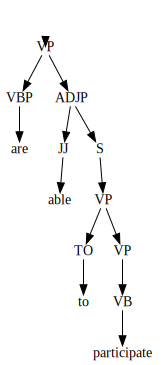

In [82]:
display_tree(fromstring(tree_parse2(tgt_seq)))

### Map phrase index to word index

In [63]:
p_i = 0
p_s = 0
p_e = phrase_token_output['phrase_offsets'][p_i][1]
p_len = 0
phrase2word = []
new_p = True
word_count = 0
for w_s, w_e in phrase_token_output['word_offsets']:
    
    if new_p:
        p_s = word_count
        new_p = False
    
    if w_e == p_e:
        phrase2word.append([p_s, word_count+1])
        new_p = True
        p_i = min(p_i + 1, len(phrase_token_output['phrase_offsets']) - 1)
        p_e = phrase_token_output['phrase_offsets'][p_i][1]
    
    word_count += 1

In [64]:
phrase2word

[[0, 1],
 [1, 2],
 [2, 4],
 [4, 5],
 [5, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [10, 11],
 [11, 12],
 [12, 13],
 [13, 14],
 [14, 15],
 [15, 16],
 [16, 17],
 [17, 18],
 [18, 19]]

In [65]:
# set color for input word
def color_words(word, color = 1):
  colors = ['\033[96m', '\033[94m', '\033[92m', '\033[0m'] # green, blue, cyan, end
  if type(word) == list:
    return f"{colors[color]}"+" ".join(word)+f"{colors[-1]}"
  else:
    return f"{colors[color]}"+word+f"{colors[-1]}"

words = phrase_token_output['words']
output = ""
for start, end in phrase2word:
  if end - start > 1:
    output += color_words(words[start:end], start%3)
  else:
    output += " ".join(words[start:end])
  output += " "
print(output)

disney has put out too many bland live remakes now and beauty and the beast is no exception . 


### Add 1 to phrase_len `[MASK]`' to the target sentence

In [66]:
phrase_masked_list = []
word2char = phrase_token_output['word_offsets']

mask_index_list = []
mask_count = 0
for p_s, p_e in phrase2word:
    if p_e - p_s >= 2:
        c_s = word2char[ p_s ][0]
        c_e = word2char[ p_e - 1][1]
        
        mask_len = p_e - p_s
        for l in range(1, mask_len+1):
            phrase_masked_list.append(tgt_seq[0:c_s] + ' [MASK]' * l + ' ' + tgt_seq[c_e:])
            mask_index_list.append([mask_count, mask_count + l])
            mask_count += l

In [67]:
tgt_seq

'Disney has put out too many bland live remakes now and Beauty and the Beast is no exception.'

In [68]:
phrase_masked_list
for sent in phrase_masked_list:
  print(sent.replace(f' {tokenizer.mask_token}', color_words(f' {tokenizer.mask_token}')))

Disney has  [MASK]  too many bland live remakes now and Beauty and the Beast is no exception.
Disney has  [MASK] [MASK]  too many bland live remakes now and Beauty and the Beast is no exception.


### Get masked token candidates from MLM model

In [69]:
encodings = tokenizer(phrase_masked_list, truncation=True, padding=True, return_token_type_ids=False, return_tensors='pt')
inputs = encodings['input_ids'].to(device)
mask_token_index = torch.where(inputs == tokenizer.mask_token_id)[1]

In [70]:
token_logits = mlm_model(inputs, attention_mask=encodings['attention_mask'].to(device)).logits
token_logits.shape

torch.Size([2, 22, 30522])

In [71]:
mask_token_logits = torch.empty(len(mask_token_index), token_logits.shape[2])

for i,ind in enumerate(mask_index_list):
    li_s = mask_index_list[i][0]
    li_e = mask_index_list[i][1]
    ind_s = mask_token_index[li_s]
    ind_e = mask_token_index[li_e - 1] + 1
        
    mask_token_logits[li_s:li_e] = token_logits[i, ind_s:ind_e, :]

In [72]:
top_8_tokens = torch.topk(mask_token_logits, 8, dim=1).indices
top_8_tokens.shape

torch.Size([3, 8])

### Here get_substitutes check the combination of word candidates and rank them by perplexity (cross_entropy loss)

In [73]:
def get_substitutes(substitutes, tokenizer, mlm_model):
    # all substitutes  list of list of token-id (all candidates)
    c_loss = nn.CrossEntropyLoss(reduction='none')
    word_list = []

    # find all possible candidates 
    all_substitutes = []
    for i in range(substitutes.size(0)):
        if len(all_substitutes) == 0:
            lev_i = substitutes[i]
            all_substitutes = [[int(c)] for c in lev_i]
        else:
            lev_i = []
            for all_sub in all_substitutes:
                for j in substitutes[i]:
                    lev_i.append(all_sub + [int(j)])
            all_substitutes = lev_i

    # all_substitutes = all_substitutes[:24]
    all_substitutes = torch.tensor(all_substitutes) # [ N, L ]
    all_substitutes = all_substitutes[:24].to(device)
    
    print(all_substitutes.shape) # (K ^ t, K)

    N, L = all_substitutes.size()
    word_predictions = mlm_model(all_substitutes)[0] # N L vocab-size
    ppl = c_loss(word_predictions.view(N*L, -1), all_substitutes.view(-1)) # [ N*L ] 
    ppl = torch.exp(torch.mean(ppl.view(N, L), dim=-1)) # N  
    
    _, word_list = torch.sort(ppl)
    word_list = [all_substitutes[i] for i in word_list]
    final_words = []
    for word in word_list[:24]:
        tokens = [tokenizer._convert_id_to_token(int(i)) for i in word]
        text = tokenizer.convert_tokens_to_string(tokens)
        final_words.append(text)
        
    del all_substitutes
    return final_words

In [74]:
for (i, (p_s, p_e)) in enumerate(mask_index_list):
    cur_phrase = ''
    substitutes = top_8_tokens[p_s:p_e]
    final_words = get_substitutes(substitutes, tokenizer, mlm_model)
    for s in substitutes:
        print(tokenizer.convert_ids_to_tokens(s))
    
    print(phrase_masked_list[i])
    for w in final_words[:5]:
        print(phrase_masked_list[i].replace((f' {tokenizer.mask_token}' * (p_e - p_s))[1:], color_words(w)))
    print()

torch.Size([8, 1])
['done', 'made', 'seen', 'produced', 'created', 'had', 'released', 'got']
Disney has  [MASK]  too many bland live remakes now and Beauty and the Beast is no exception.
Disney has  got  too many bland live remakes now and Beauty and the Beast is no exception.
Disney has  made  too many bland live remakes now and Beauty and the Beast is no exception.
Disney has  had  too many bland live remakes now and Beauty and the Beast is no exception.
Disney has  done  too many bland live remakes now and Beauty and the Beast is no exception.
Disney has  released  too many bland live remakes now and Beauty and the Beast is no exception.

torch.Size([24, 2])
['been', 'done', 'put', 'not', 'already', 'also', 'just', 'obviously']
['far', 'doing', 'done', 'making', 'seen', 'made', 'producing', 'on']
Disney has  [MASK] [MASK]  too many bland live remakes now and Beauty and the Beast is no exception.
Disney has  been on  too many bland live remakes now and Beauty and the Beast is no exce

## Importance Score

In [75]:
from transformers import AutoModelForSequenceClassification

target_model = AutoModelForSequenceClassification.from_pretrained("textattack/distilbert-base-uncased-imdb").to(device)

In [76]:
model_name = "bert-large-uncased-whole-word-masking"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [77]:
# 1. retrieve logits and label from the target model
inputs = tokenizer(entry['text'], return_tensors="pt", truncation=True, max_length=512, return_token_type_ids=False)
orig_logits = target_model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))[0].squeeze()
orig_probs  = torch.softmax(orig_logits, -1)
orig_label = torch.argmax(orig_probs)
current_prob = orig_probs.max()

### Mask each phrase with `[UNK]` token and compute the confidence change

In [78]:
# return units masked with UNK at each position in the sequence
def _get_unk_masked(units):
    len_text = len(units)
    masked_units = []
    for i in range(len_text - 1):
        masked_units.append(units[0:i] + ['[UNK]'] + units[i + 1:])
    
    # list of masked basic units
    return masked_units

'''
input units should be phrase tokens
'''
def get_important_scores(units, tgt_model, orig_prob, orig_label, orig_probs, tokenizer, batch_size=8, max_length=512):
    masked_units = _get_unk_masked(units)
    texts = [' '.join(units) for units in masked_units]  # list of text of masked units
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(tokenizer)
    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_token_type_ids=False, return_tensors='pt')
    
    eval_data = TensorDataset(encodings['input_ids'], encodings['attention_mask'])

    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=batch_size)
    leave_1_probs = []
    
    tgt_model.eval() #make sure in inference stage
    
    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids = batch[0].to(device)      # input ids
            attention_mask = batch[1].to(device) # attention mask
        
            leave_1_prob_batch = tgt_model(input_ids, attention_mask=attention_mask)[0]
            leave_1_probs.append(leave_1_prob_batch)
        
    leave_1_probs = torch.cat(leave_1_probs, dim=0)  # words, num-label
    leave_1_probs = torch.softmax(leave_1_probs, -1)
    leave_1_probs_argmax = torch.argmax(leave_1_probs, dim=-1)
    import_scores = (orig_prob
                     - leave_1_probs[:, orig_label] # how the probability of original label decreases
                     +
                     (leave_1_probs_argmax != orig_label).float() # new label not equal to original label
                     * (leave_1_probs.max(dim=-1)[0] - torch.index_select(orig_probs, 0, leave_1_probs_argmax))
                     ).data.cpu().numpy()           # probability of changed label

    return import_scores

In [79]:
importance = get_important_scores(entry['phrases'], target_model, current_prob, orig_label, orig_probs, tokenizer, batch_size=8, max_length=512)

PreTrainedTokenizer(name_or_path='bert-large-uncased-whole-word-masking', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [80]:
sorted_indices = torch.argsort(torch.tensor(importance), dim=-1, descending=True).cpu()
sorted_units = np.array(entry['phrases'])[sorted_indices]
[(u,i) for (u,i) in zip(sorted_units, importance[sorted_indices])]

[('and', 1.129978),
 ('bland', 1.1032591),
 ('the', 1.0143657),
 ('beast', 0.71768385),
 ('exception', 0.62257254),
 ('is', 0.5944748),
 ('beauty', 0.52823466),
 ('and', 0.24859142),
 ('live', 0.2329458),
 ('no', 0.1979633),
 ('now', 0.008240223),
 ('remakes', -0.030231714),
 ('too', -0.08739191),
 ('many', -0.092213035),
 ('disney', -0.13981366),
 ('put out', -0.16544706),
 ('has', -0.19628477)]

## Semantic Constraint

### Mask the Word 'bland'

In [81]:
word = 'bland'
word_start = tgt_seq.find(word)

In [82]:
phrase_masked_list = (tgt_seq[0:word_start] + ' [MASK] ' + tgt_seq[word_start+len(word):])
phrase_masked_list

'Disney has put out too many  [MASK]  live remakes now and Beauty and the Beast is no exception.'

In [83]:
encodings = tokenizer(phrase_masked_list, truncation=True, padding=True, return_token_type_ids=False, return_tensors='pt')
inputs = encodings['input_ids'].to(device)
mask_token_index = torch.where(inputs == tokenizer.mask_token_id)[1]
token_logits = mlm_model(inputs, attention_mask=encodings['attention_mask'].to(device)).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_8_tokens = torch.topk(mask_token_logits, 8, dim=1).indices

In [84]:
print(phrase_masked_list)
for t in tokenizer.convert_ids_to_tokens(top_8_tokens[0]):
    print(phrase_masked_list.replace(f' {tokenizer.mask_token} ', color_words(t)))

Disney has put out too many  [MASK]  live remakes now and Beauty and the Beast is no exception.
Disney has put out too many disney live remakes now and Beauty and the Beast is no exception.
Disney has put out too many animated live remakes now and Beauty and the Beast is no exception.
Disney has put out too many traditionally live remakes now and Beauty and the Beast is no exception.
Disney has put out too many original live remakes now and Beauty and the Beast is no exception.
Disney has put out too many classic live remakes now and Beauty and the Beast is no exception.
Disney has put out too many epic live remakes now and Beauty and the Beast is no exception.
Disney has put out too many limited live remakes now and Beauty and the Beast is no exception.
Disney has put out too many to live remakes now and Beauty and the Beast is no exception.


### No Mask - implicit semantic check

In [85]:
phrase_masked_list = tgt_seq

encodings = tokenizer(phrase_masked_list, truncation=True, padding=True, return_token_type_ids=False, return_tensors='pt')
inputs = encodings['input_ids'].to(device)
mask_token_index = tokenizer.convert_ids_to_tokens(inputs[0]).index(word)
token_logits = mlm_model(inputs, attention_mask=encodings['attention_mask'].to(device)).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_8_tokens = torch.topk(mask_token_logits, 8, dim=-1).indices

In [86]:
print(phrase_masked_list)
for t in tokenizer.convert_ids_to_tokens(top_8_tokens):
    print(phrase_masked_list.replace(word, color_words(t)))

Disney has put out too many bland live remakes now and Beauty and the Beast is no exception.
Disney has put out too many disney live remakes now and Beauty and the Beast is no exception.
Disney has put out too many animated live remakes now and Beauty and the Beast is no exception.
Disney has put out too many original live remakes now and Beauty and the Beast is no exception.
Disney has put out too many live live remakes now and Beauty and the Beast is no exception.
Disney has put out too many traditionally live remakes now and Beauty and the Beast is no exception.
Disney has put out too many new live remakes now and Beauty and the Beast is no exception.
Disney has put out too many limited live remakes now and Beauty and the Beast is no exception.
Disney has put out too many long live remakes now and Beauty and the Beast is no exception.


Observation:
**Not deleting the word to be masked out does enforce semantic meaning.**

### What about multi-words?

In [42]:
mask_token_index = torch.tensor([3,5])
token_logits = mlm_model(inputs, attention_mask=encodings['attention_mask'].to(device)).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_8_tokens = torch.topk(mask_token_logits, 8, dim=-1).indices

In [43]:
final_words = get_substitutes(top_8_tokens, tokenizer, mlm_model)

torch.Size([24, 2])


In [44]:
print(phrase_masked_list)
for w in final_words[:5]:
    print(phrase_masked_list.replace((f'put out'), color_words(w)))
print()

Disney has put out too many bland sequals now and Frozen 2 is no exception.
Disney has put to too many bland sequals now and Frozen 2 is no exception.
Disney has put a too many bland sequals now and Frozen 2 is no exception.
Disney has put so too many bland sequals now and Frozen 2 is no exception.
Disney has sent so too many bland sequals now and Frozen 2 is no exception.
Disney has put many too many bland sequals now and Frozen 2 is no exception.



Observation:
**Should not do this for phrases. Since it still enforces single-word semangtic meaning**